### Part 1: Import necessary libraries and load the dataset

In [25]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import sklearn as sk
import seaborn as sns
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, f1_score
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [26]:
#load train & test dataset

source = pd.read_csv("train.csv")
testdata = pd.read_csv("test.csv")

### Part 2: Data pre-processing

In [27]:
#create replacement dict

cleanup = {"LotShape" : {"Reg":4, "IR1":3, "IR2":2, "IR3":1},
           "LandSlope": {"Gtl":3, "Mod":2, "Sev":1},
           "HouseStyle": {"1Story":1, "1.5Fin":1.5, "1.5Unf":1.25, "2Story":2, "2.5Fin":2.5, "2.5Unf":2.25, "SFoyer": 1.25, "SLvl": 1.5}, 
           #code external quality based on the numbers assigned to OverallCond & OverallQual
           "ExterQual": {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1},
           "ExterCond" : {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1}, 
           "BsmtQual" : {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1, "NA": 0},
           "BsmtCond": {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1, "NA": 0},
           #split levels or foyers typically score average or above in bsmtExposure
           "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0},
           "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "NA":0},
           "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ":4, "Rec":3, "LwQ":2, "Unf":1, "NA":0},
           "HeatingQC": {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1},
           "CentralAir": {"N": 0, "Y": 1},
           "KitchenQual": {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1},
           "Functional": {"Typ":8, "Min1":7, "Min2":6, "Mod":5, "Maj1":4, "Maj2":3, "Sev":2, "Sal":1},
           "FireplaceQu": {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1, "NA": 0},
           "GarageFinish": {"Fin":3, "RFn":2, "Unf":1, "NA":0},
           "GarageQual": {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1, "NA": 0},
           "GarageCond": {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "Po": 1, "NA": 0},
           "PavedDrive": {"Y": 2, "P":1, "N":0},
           "PoolQC": {"Ex": 9, "Gd": 7, "TA": 5, "Fa": 3, "NA": 0}}

df = source.replace(cleanup)
df2 = testdata.replace(cleanup)

In [28]:
#onehot encoding
catlist = ['MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
df_onehot = pd.get_dummies(df[catlist], prefix = '', prefix_sep = '')
df_onehot['Id'] = df['Id']

df2_onehot = pd.get_dummies(df2[catlist], prefix = '', prefix_sep = '')
df2_onehot['Id'] = df2['Id']

In [29]:
#drop the one-hot coded columns from df
df.drop(catlist, axis = 1, inplace = True)
df2.drop(catlist, axis = 1, inplace = True)

In [30]:
#merge the remaining of df with df_onehot
df = df.join(df_onehot.set_index('Id'), on = 'Id')
df2 = df2.join(df2_onehot.set_index('Id'), on = 'Id')

In [31]:
#identify null values
df.isnull().sum()

Id                  0
MSSubClass          0
LotFrontage       259
LotArea             0
LotShape            0
LandSlope           0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea          8
ExterQual           0
ExterCond           0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
HeatingQC           0
CentralAir          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond

In [32]:
#Fill NaN values with 0s
df = df.fillna(0)
df2 = df2.fillna(0)

In [33]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,C (all),FV,RH,RL,RM,Grvl,Pave,Grvl,Pave,Bnk,HLS,Low,Lvl,AllPub,NoSeWa,Corner,CulDSac,FR2,FR3,Inside,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNn,1Fam,2fmCon,Duplex,Twnhs,TwnhsE,Flat,Gable,Gambrel,Hip,Mansard,Shed,ClyTile,CompShg,Membran,Metal,Roll,Tar&Grv,WdShake,WdShngl,AsbShng,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing,AsbShng,AsphShn,Brk Cmn,BrkFace,CBlock,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,Stone,Stucco,VinylSd,Wd Sdng,Wd Shng,BrkCmn,BrkFace,None,Stone,BrkTil,CBlock,PConc,Slab,Stone,Wood,Floor,GasA,GasW,Grav,OthW,Wall,FuseA,FuseF,FuseP,Mix,SBrkr,2Types,Attchd,Basment,BuiltIn,CarPort,Detchd,GdPrv,GdWo,MnPrv,MnWw,Gar2,Othr,Shed,TenC,COD,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.00000,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.

In [34]:
#check data type
df.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
LotShape           int64
LandSlope          int64
HouseStyle       float64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
ExterQual          int64
ExterCond          int64
BsmtQual         float64
BsmtCond         float64
BsmtExposure     float64
BsmtFinType1     float64
BsmtFinSF1         int64
BsmtFinType2     float64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
HeatingQC          int64
CentralAir         int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual        int64
TotRmsAbvGrd       int64
Functional         int64
Fireplaces         int64
FireplaceQu      float64


In [35]:
#change uint8 type into float type
df = df.astype(float)
df2 = df2.astype(float)

In [36]:
print(df.shape)
print(df2.shape)

(1460, 220)
(1459, 204)


### Part 3: Extrapolatory analysis

In [37]:
#graph the distribution of salesprice
min = df['SalePrice'].min()
max = df['SalePrice'].max()
print(min, max)

34900.0 755000.0


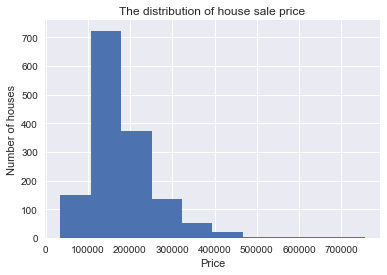

In [38]:
df['SalePrice'].plot(kind = 'hist')

plt.title('The distribution of house sale price')
plt.ylabel('Number of houses')
plt.xlabel('Price')
plt.show()

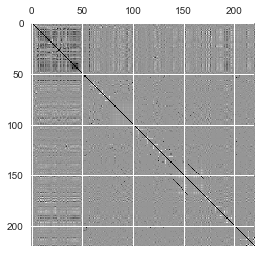

In [39]:
#Correlation matrix
plt.matshow(df.corr())
plt.show()

In [40]:
df.corr()

,Id,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MoSold,YrSold,SalePrice,C (all),FV,RH,RL,RM,Grvl,Pave,Grvl,Pave,Bnk,HLS,Low,Lvl,AllPub,NoSeWa,Corner,CulDSac,FR2,FR3,Inside,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,NAmes,NPkVill,NWAmes,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNe,RRNn,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNn,1Fam,2fmCon,Duplex,Twnhs,TwnhsE,Flat,Gable,Gambrel,Hip,Mansard,Shed,ClyTile,CompShg,Membran,Metal,Roll,Tar&Grv,WdShake,WdShngl,AsbShng,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing,AsbShng,AsphShn,Brk Cmn,BrkFace,CBlock,CmentBd,HdBoard,ImStucc,MetalSd,Other,Plywood,Stone,Stucco,VinylSd,Wd Sdng,Wd Shng,BrkCmn,BrkFace,None,Stone,BrkTil,CBlock,PConc,Slab,Stone,Wood,Floor,GasA,GasW,Grav,OthW,Wall,FuseA,FuseF,FuseP,Mix,SBrkr,2Types,Attchd,Basment,BuiltIn,CarPort,Detchd,GdPrv,GdWo,MnPrv,MnWw,Gar2,Othr,Shed,TenC,COD,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD,Abnorml,AdjLand,Alloca,Family,Normal,Partial
Id,1.000000,0.011156,-1.976132e-02,-0.033226,0.024071,-0.005847,-0.001234,-0.028365,0.012609,-0.012713,-0.021998,-0.051071,0.005039,0.029860,-0.030502,0.010732,0.017320,-0.016882,-0.005024,-0.030615,-0.005968,-0.007940,-0.015415,-0.015001,0.009821,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.014973,0.027239,-0.002701,-0.019772,0.002706,0.013491,0.013821,0.016570,0.017634,0.013812,0.007589,0.005971,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,0.046141,-0.006242,0.021172,0.000712,-0.021917,-0.024689,-0.012020,0.032453,0.031034,-0.032379,-0.008916,0.008916,0.002413,-0.001658,0.015040,0.016800,-0.008845,-0.015657,-0.013324,0.013324,-0.054832,-0.003973,0.015804,0.017722,0.040852,0.011187,0.004218,-0.002825,0.002039,-0.041662,-0.002939,0.031860,0.020865,0.010585,-0.050869,0.000644,0.012646,0.007591,0.009520,0.050052,0.034188,-0.067622,-0.024950,0.034681,-0.008031,-0.031818,0.014985,-0.019097,0.021925,-0.023069,-0.019103,0.028614,-0.004457,-0.010127,0.000825,-0.022919,0.016785,-0.033086,0.000487,-0.011600,-0.049484,0.041539,-0.009100,-0.004877,0.031090,0.016989,-0.038754,-0.017741,-0.022777,0.028174,-0.003186,0.019292,-0.012724,-0.030540,-0.024046,0.040840,-0.029043,0.045740,0.035313,0.013775,-0.028481,-0.037860,0.033885,0.010271,-0.010835,-0.033633,0.008696,0.017486,-0.002153,0.006854,0.039786,0.006315,0.010591,0.028419,0.030282,-0.022465,0.031504,-0.007172,-0.008072,-0.026184,-0.012865,0.021657,-0.010964,-0.004717,0.014713,0.039786,0.010945,0.022900,0.004177,0.019772,-0.008355,-0.024483,0.042408,-0.006599,-0.016633,-0.024875,0.000827,-0.040379,-0.036425,0.024897,0.024760,3.737772e-03,-0.004646,-0.005419,0.015695,0.024082,0.007447,0.036742,-0.038160,-0.000839,0.025656,0.050002,0.020986,-0.024989,-0.022635,-0.058838,-0.020592,0.040349,-0.003760,0.004024,0.041520,-0.015589,-0.017472,0.003919,0.010650,0.009162,-0.021589,0.002678,0.005141,0.005229,-0.048244,0.040780,-0.005157,0.021204,-0.016301,-0.004412,-0.058765,-0.020738,-0.018998,0.038920,0.026133,0.007009,-0.034852,-0.009018,0.004865,0.015881,-0.020738
MSSubClass,0.011156,1.000000,-2.150229e-01,-0.139781,0.115361,0.025672,0.441209,0.032628,-0.059316,0.027850,0.040581,0.023573,0.016178,-0.064686,0.055568,-0.015484,0.051150,0.027389,-0.069836,-0.024330,-0.065649,-0.140759,-0.238518,-0.019458,-

### Part 4: Train model using the training set

In [41]:
#Features in the training set
Feature = df.drop(['Id', 'SalePrice'], axis = 1)
X = Feature
y = df['SalePrice'].values

In [42]:
#Features in the test set
X_real = df2.drop(['Id'], axis = 1)

In [43]:
#Align training set and test set features
X, X_real = X.align(X_real, join='inner', axis=1) 

In [44]:
print(X.shape)
print(X_real.shape)

(1460, 260)
(1459, 260)


In [45]:
#normalize X
#X = preprocessing.StandardScaler().fit(X).transform(X)
#X[0:5]

In [46]:
#split the dataset into micro-train and micro-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (1022, 260) (1022,)
Test set:  (438, 260) (438,)


In [47]:
#create linear regression object
reg = linear_model.LinearRegression()
#train the model
reg.fit(X_train, y_train)
#make prediction
y_pred = reg.predict(X_test)

In [48]:
#evaluation
r2_score(y_test, y_pred)

0.83771077588114151

### Part 5: Predict house price using the test set

In [49]:
#train the model with the entire train dataset
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [50]:
#predict
y_pred_real = reg.predict(X_real)
y_pred_real[0:5]

array([ 117995.21216834,  158791.64194545,  165244.40164831,
        186333.05568886,  219382.24136083])

In [62]:
#print out prediction file
d = {"Id": df2['Id'].astype(int), "SalePrice": y_pred_real}
printout = pd.DataFrame(data = d)
#write csv file
printout.to_csv("final_submission.csv", index = False)